## Libraries

### Matplotlib

### NumPy

### Pandas


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Dataset: FoodAPS National Household Food Acquisition and Purchase Survey


In [2]:
hh_df = pd.read_csv("data/faps_household_puf.csv")

item_df = pd.read_csv("data/faps_fahitem_puf.csv")
nutrient_df = pd.read_csv("data/faps_fahnutrients.csv")

In [3]:
ID_VARIABLES = ["hhnum", "eventid", "itemnum"]
REQUIRED_VARIABLES = [*ID_VARIABLES, "totgramsedible", "totsug"]

food_df = item_df.merge(nutrient_df[REQUIRED_VARIABLES], how="left", on=ID_VARIABLES)

## Data Preprocessing


In [4]:
hh_df = hh_df[(hh_df["numguests"] == 0) & (hh_df["hhsizechange"] == 0)]

In [5]:
import enum


class SNAPNowAdmin(enum.Enum):
    NO_MATCH = 0
    CONFIRMED_SNAP = 1
    CONFIRMED_NON_SNAP = 2
    VALID_SKIP = -996


hh_df = hh_df[
    (hh_df["snapnowadmin"] == SNAPNowAdmin.CONFIRMED_SNAP.value)
    | (hh_df["snapnowadmin"] == SNAPNowAdmin.CONFIRMED_NON_SNAP.value)
]

TODO: (NOTE for write-up) This is specific part is for masking, you can just Google it and do a short explanation for
it. I did it because it was recommended by AI (LMAO) and it's easier for the `groupby`s later on.


In [6]:
hh_df["snap_status"] = hh_df["snapnowadmin"].replace(
    {SNAPNowAdmin.CONFIRMED_SNAP.value: 1, SNAPNowAdmin.CONFIRMED_NON_SNAP.value: 0}
)

/var/folders/6r/g5w3tmhx0tj1ygxtm4032mk40000gn/T/ipykernel_89966/2261300958.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hh_df["snap_status"] = hh_df["snapnowadmin"].replace(


In [7]:
food_df = food_df[(food_df["totgramsedible"] > 0) & (food_df["totsug"].notna())]

In [8]:
food_df["sugar_amount"] = (food_df["totsug"] / 100) * food_df["totgramsedible"]
food_df["sugar_density"] = food_df["totsug"]

TODO: (NOTE for write-up) Just Google `22.5`, I found it there.


In [ ]:
HIGH_SUGAR_THRESHOLD = 22.5

food_df["high_sugar_status"] = (food_df["totsug"] > HIGH_SUGAR_THRESHOLD).astype(int)
food_df["High_sugar_amount"] = food_df["totgramsedible"] * food_df["high_sugar_status"]

## Exploratory Data Analysis Question 1

**_Are SNAP households more likely to acquire sugary foods than non-SNAP households?_**


In [10]:
hh_sugar_df = (
    food_df.groupby("hhnum")
    .agg(total_sugar_amount=("sugar_amount", "sum"), total_amount=("totgramsedible", "sum"))
    .reset_index()
)
hh_sugar_df["sugar_share"] = hh_sugar_df["total_sugar_amount"] / hh_sugar_df["total_amount"]

In [11]:
hh_sugar_df = hh_sugar_df.merge(hh_df[["hhnum", "snap_status"]], how="left", on="hhnum")

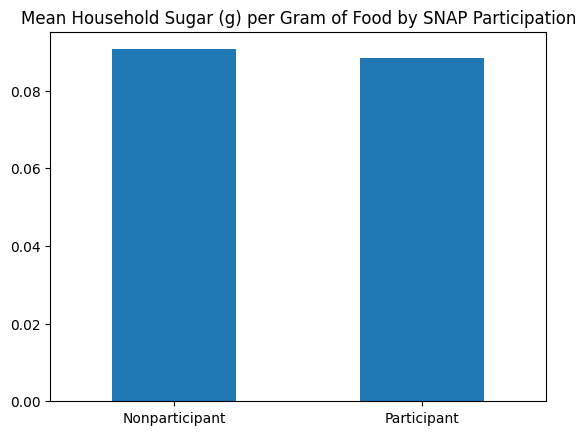

In [12]:
ax = hh_sugar_df.groupby("snap_status")["sugar_share"].mean().plot(kind="bar")

ax.set_xticks([0, 1])
ax.set_xticklabels(["Nonparticipant", "Participant"], rotation=0)

ax.set_title("Mean Household Sugar (g) per Gram of Food by SNAP Participation")
ax.set_xlabel("")

plt.show()

### Household Sugar per Gram of Food


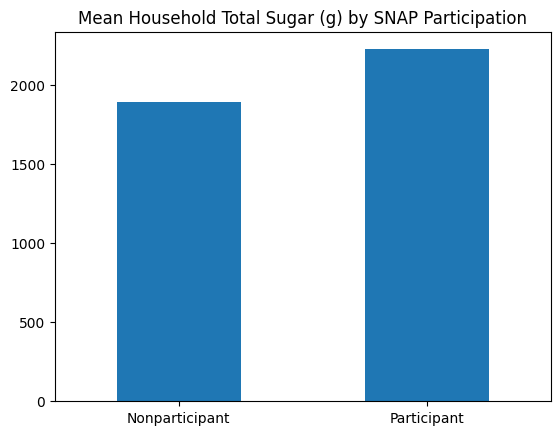

In [13]:
ax = hh_sugar_df.groupby("snap_status")["total_sugar_amount"].mean().plot(kind="bar")

ax.set_xticks([0, 1])
ax.set_xticklabels(["Nonparticipant", "Participant"], rotation=0)

ax.set_title("Mean Household Total Sugar (g) by SNAP Participation")
ax.set_xlabel("")

plt.show()

### Household Total Sugar


In [14]:
high_sugar_share = food_df.groupby("hhnum")["high_sugar_status"].mean().reset_index()

In [15]:
high_sugar_share = high_sugar_share.merge(hh_df[["hhnum", "snap_status"]], on="hhnum")

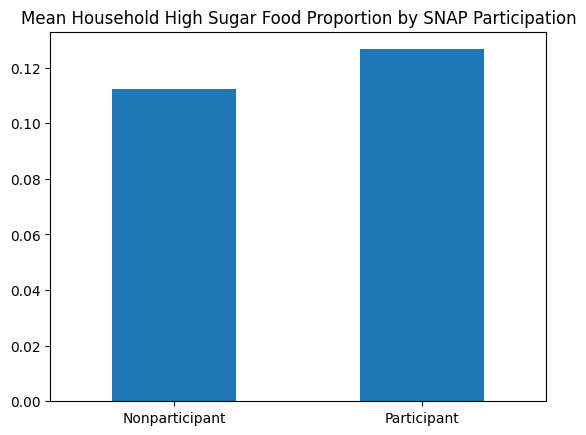

In [16]:
ax = high_sugar_share.groupby("snap_status")["high_sugar_status"].mean().plot(kind="bar")

ax.set_xticks([0, 1])
ax.set_xticklabels(["Nonparticipant", "Participant"], rotation=0)

ax.set_title("Mean Household High Sugar Food Proportion by SNAP Participation")
ax.set_xlabel("")

plt.show()

### Household High Sugar Food Proportion


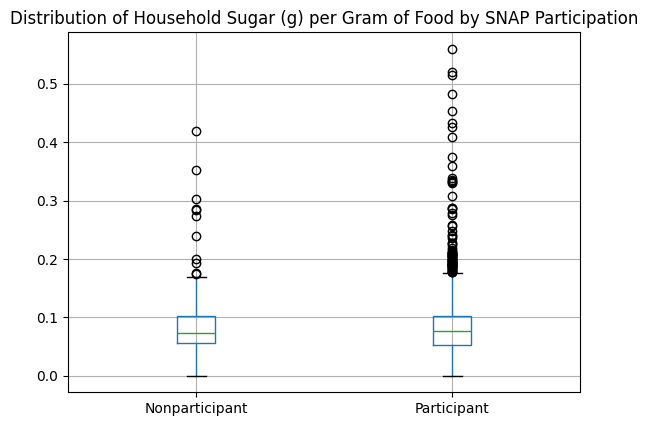

In [17]:
hh_sugar_df.boxplot(column="sugar_share", by="snap_status")

plt.xticks([1, 2], ["Nonparticipant", "Participant"])

plt.title("Distribution of Household Sugar (g) per Gram of Food by SNAP Participation")
plt.suptitle("")
plt.xlabel("")

plt.show()

### Household Sugar per Gram of Food Distribution


## Exploratory Data Analysis Question 2

**_Do SNAP households exhibit greater variability in sugar density across purchased items compared to non-SNAP households?_**


In [18]:
hh_sugar_variability_df = food_df.groupby("hhnum").agg(sugar_sd=("sugar_density", "std")).reset_index()

In [19]:
hh_sugar_variability_df = hh_sugar_variability_df.merge(hh_df[["hhnum", "snap_status"]], how="left", on="hhnum")

In [20]:
hh_sugar_variability_df.groupby("snap_status")["sugar_sd"].describe()

,count,mean,std,min,25%,50%,75%,max
snap_status,,,,,,,,
0.0,101.0,14.077620,9.525857,0.0,5.826651,12.371478,19.140549,43.906323
1.0,977.0,13.828645,9.101095,0.0,6.023803,12.728962,19.636405,66.991296


### Household Sugar Variability


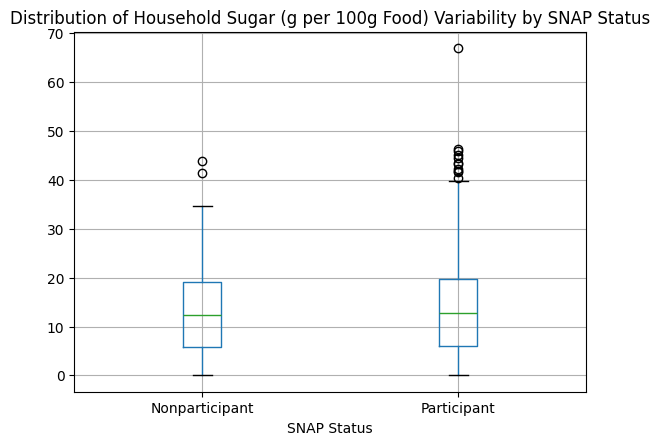

In [21]:
hh_sugar_variability_df.boxplot(column="sugar_sd", by="snap_status")

plt.xticks([1, 2], ["Nonparticipant", "Participant"])

plt.title("Distribution of Household Sugar (g per 100g Food) Variability by SNAP Status")
plt.suptitle("")
plt.xlabel("")

plt.show()

### Household Sugar Variability Distribution


## Exploratory Data Analysis Question 3

**_Are SNAP households more likely to have a higher share of their total acquired food coming from high-sugar items?_**
